In [1]:
import dv_processing as dv
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_save_max_acc_refac

device = get_device()
dataset = 'davis'
total_time = 250
batch_size = 5
folder_name = 'ABCXO_joined_one_sample'

#folder_name = 'ABCXO_one_sample'

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  #sensor_size_to = 45,
                  sensor_size_to = 32,
                  folder_name = folder_name)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()


Running on: cuda:0
[CenterCrop(sensor_size=(240, 180, 2), size=(128, 128)), Downsample(time_factor=1, spatial_factor=0.25, sensor_size=None, target_size=None), ToFrame(sensor_size=(32, 32, 2), time_window=None, event_count=None, n_time_bins=250, n_event_bins=None, overlap=0, include_incomplete=False)]


In [2]:
dataset_dict['time_ms'] = 250

structure = (24, 2, 'f')

extra_kwargs = {}

snn = SNN(dataset_dict=dataset_dict, structure=structure, tau_m=50.0, win=total_time, loss_fn='spk_count', batch_size=batch_size, device=device, 
          **extra_kwargs)
# snn.input2spike_th = 0.5
snn.set_layers()
snn.to(device)

Delta t: 1.0 ms
Delta t: 1.0 ms
Delta t: 1.0 ms


SNN(
  (criterion): MSELoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=2048, out_features=24, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=24, out_features=24, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=24, out_features=5, bias=False)
    )
  )
)

In [3]:
snn.debug = True
snn.init_state_logger()
a, b = snn.test(test_loader)

1
Test Loss: 0.20392000675201416
Avg spk_count per neuron for all 250 time-steps 525.5
Test Accuracy of the model on the test samples: 0.000



In [4]:
snn.spike_state.keys()

dict_keys(['input', 'l1', 'l2', 'output'])

In [5]:
i_spikes = snn.spike_state['input'].detach().cpu().numpy()

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

def plot_spikes(t_index):
    for x in range(1):
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.imshow(i_spikes[t_index, x, 32*32:].reshape(32, 32), aspect='auto')
        plt.title(f'Time {t_index}, Batch {x}, Part 1')
        plt.subplot(122)
        plt.imshow(i_spikes[t_index, x, :32*32].reshape(32, 32), aspect='auto')
        plt.title(f'Time {t_index}, Batch {x}, Part 2')

        plt.figure(figsize=(10, 10))
        plt.imshow(i_spikes[:, x, :].T, aspect='auto')
        plt.title(f'Full Time Series, Batch {x}')
        plt.show()

slider = widgets.IntSlider(min=0, max=i_spikes.shape[0]-1, step=1, value=75, description='Time Index')
widgets.interact(plot_spikes, t_index=slider)

# for x in range(batch_size):

#     plt.figure(figsize=(10, 5))
#     plt.subplot(121)
#     plt.imshow(i_spikes[75, x, :32*32].reshape(32, 32), aspect='auto')
#     plt.subplot(122)
#     plt.imshow(i_spikes[75, x, 32*32:].reshape(32, 32), aspect='auto')

#     plt.figure(figsize=(10, 10))
#     plt.imshow(i_spikes[:, x, :].T, aspect='auto')

interactive(children=(IntSlider(value=75, description='Time Index', max=249), Output()), _dom_classes=('widget…

<function __main__.plot_spikes(t_index)>

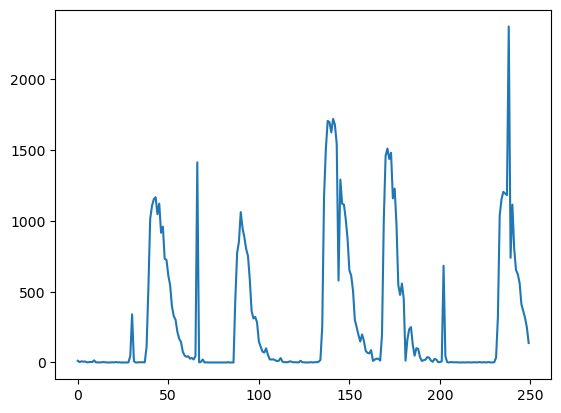

In [7]:
plt.plot(i_spikes[:, 0, :].sum(axis=1))

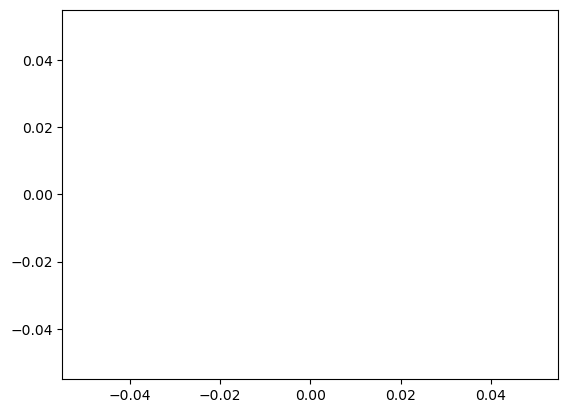

In [8]:
plt.plot(i_spikes[:, 0, :].sum(axis=1)[800:2000])